Credits: [Pytorch Geometric Tutorials](https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT?usp=sharing)

In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.1.0+cu118


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install ggplot

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 26.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-5u59khfp
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-5u59khfp
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 44c9c1290b6ad9eeb0378df30e8397e7f5ea6383
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl

### Loading datasets <br>
They are already split into train, test, validation sets during preprocessing.

In [ ]:
# Upload data folder from github to ./

In [ ]:
# loading dataset
import torch
from torch_geometric.data import HeteroData
from torch import Tensor

train_data = torch.load('./train.pt')
test_data = torch.load('./test.pt')
val_data = torch.load('./val.pt')
train_data,val_data,test_data

(HeteroData(
   movie={ x=[9742, 404] },
   user={ num_nodes=610 },
   (user, rates, movie)={
     edge_index=[2, 56469],
     edge_label=[24201],
     edge_label_index=[2, 24201],
   },
   (movie, rev_rates, user)={ edge_index=[2, 56469] }
 ),
 HeteroData(
   movie={ x=[9742, 404] },
   user={ num_nodes=610 },
   (user, rates, movie)={
     edge_index=[2, 90753],
     edge_label=[30249],
     edge_label_index=[2, 30249],
   },
   (movie, rev_rates, user)={ edge_index=[2, 90753] }
 ),
 HeteroData(
   movie={ x=[9742, 404] },
   user={ num_nodes=610 },
   (user, rates, movie)={
     edge_index=[2, 80670],
     edge_label=[30249],
     edge_label_index=[2, 30249],
   },
   (movie, rev_rates, user)={ edge_index=[2, 80670] }
 ))

In [ ]:
train_data.num_nodes, train_data.metadata()

(10352,
 (['movie', 'user'],
  [('user', 'rates', 'movie'), ('movie', 'rev_rates', 'user')]))

## Batching
It is difficult to store large graphs in memory so we need to create subgraphs. We can use LinkNeighborLoader to sample graphs and we can specify that we want 'n' hops and at each hop, sample 'i' neighbors

In [ ]:
from torch_geometric.loader import LinkNeighborLoader

# Define seed edges: Which edges to start sampling from.
# In train, it can start at any point but in test and val, it is smaller
edge_label_index = train_data["user", "rates", "movie"].edge_label_index
edge_label = train_data["user", "rates", "movie"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,  #
    num_neighbors=[30,20],  # This list size is number of hops. It means sample 30 neighbors at 1st hop and 20 at 2nd hop
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True,
)


## Model Definition

Lets define a graph neural network. There are multiple possible layer types but we will use nn.SAGEConv initially. As there are 2 types of nodes in graph, we will need to convert model to hetegenous also.

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class Classifier(torch.nn.Module):
    def forward(self, user: Tensor, movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = user[edge_label_index[0]]
        edge_feat_movie = movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.movie_lin = torch.nn.Linear(404, hidden_channels)
        # create [hidden_channels] length embeddings for users
        self.user_emb = torch.nn.Embedding(train_data["user"].num_nodes, hidden_channels)
        # create [hidden_channels] length embeddings for movie
        self.movie_emb = torch.nn.Embedding(train_data["movie"].num_nodes, hidden_channels)

        # GNN: Homogeneous by default:
        self.gnn = GNN(hidden_channels)

        # Making GNN heterogeneous:
        self.gnn = to_hetero(self.gnn, metadata=train_data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
            x_dict = {
              "user": self.user_emb(data["user"].n_id),
              "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].n_id),
            }

            # `x_dict` holds feature matrices of all node types
            # `edge_index_dict` holds all edge indices of all edge types
            x_dict = self.gnn(x_dict, data.edge_index_dict)

            pred = self.classifier(
                x_dict["user"],
                x_dict["movie"],
                data["user", "rates", "movie"].edge_label_index,
            )

            return pred


model = Model(hidden_channels=128)
print(model)

Model(
  (movie_lin): Linear(in_features=404, out_features=128, bias=True)
  (user_emb): Embedding(610, 128)
  (movie_emb): Embedding(9742, 128)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__rates__movie): SAGEConv(128, 128, aggr=mean)
      (movie__rev_rates__user): SAGEConv(128, 128, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__movie): SAGEConv(128, 128, aggr=mean)
      (movie__rev_rates__user): SAGEConv(128, 128, aggr=mean)
    )
  )
  (classifier): Classifier()
)


/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


## Training

In [ ]:
import tqdm # For progress bar
import torch.nn.functional as F
import torch_sparse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_lst = []

for epoch in range(1, 20):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        # Move `sampled_data` to the respective `device`
        sampled_data.to(device)
        # Run `forward` pass of the model
        pred = model.forward(sampled_data)
        # Apply binary cross entropy via
        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")
    loss_lst.append(total_loss / total_examples)

Device: 'cpu'


100%|██████████| 190/190 [00:24<00:00,  7.81it/s]


Epoch: 001, Loss: 0.4144


100%|██████████| 190/190 [00:22<00:00,  8.31it/s]


Epoch: 002, Loss: 0.3235


100%|██████████| 190/190 [00:24<00:00,  7.92it/s]


Epoch: 003, Loss: 0.2870


100%|██████████| 190/190 [00:25<00:00,  7.56it/s]


Epoch: 004, Loss: 0.2689


100%|██████████| 190/190 [00:25<00:00,  7.31it/s]


Epoch: 005, Loss: 0.2514


100%|██████████| 190/190 [00:25<00:00,  7.59it/s]


Epoch: 006, Loss: 0.2375


100%|██████████| 190/190 [00:23<00:00,  7.94it/s]


Epoch: 007, Loss: 0.2254


100%|██████████| 190/190 [00:23<00:00,  8.25it/s]


Epoch: 008, Loss: 0.2143


100%|██████████| 190/190 [00:24<00:00,  7.66it/s]


Epoch: 009, Loss: 0.2044


100%|██████████| 190/190 [00:23<00:00,  7.92it/s]


Epoch: 010, Loss: 0.1939


100%|██████████| 190/190 [00:22<00:00,  8.33it/s]


Epoch: 011, Loss: 0.1857


100%|██████████| 190/190 [00:23<00:00,  7.93it/s]


Epoch: 012, Loss: 0.1772


100%|██████████| 190/190 [00:23<00:00,  7.93it/s]


Epoch: 013, Loss: 0.1702


100%|██████████| 190/190 [00:22<00:00,  8.33it/s]


Epoch: 014, Loss: 0.1666


100%|██████████| 190/190 [00:24<00:00,  7.86it/s]


Epoch: 015, Loss: 0.1614


100%|██████████| 190/190 [00:24<00:00,  7.84it/s]


Epoch: 016, Loss: 0.1575


100%|██████████| 190/190 [00:23<00:00,  8.21it/s]


Epoch: 017, Loss: 0.1502


100%|██████████| 190/190 [00:24<00:00,  7.87it/s]


Epoch: 018, Loss: 0.1463


100%|██████████| 190/190 [00:24<00:00,  7.73it/s]

Epoch: 019, Loss: 0.1462


Text(0, 0.5, 'Train Loss')

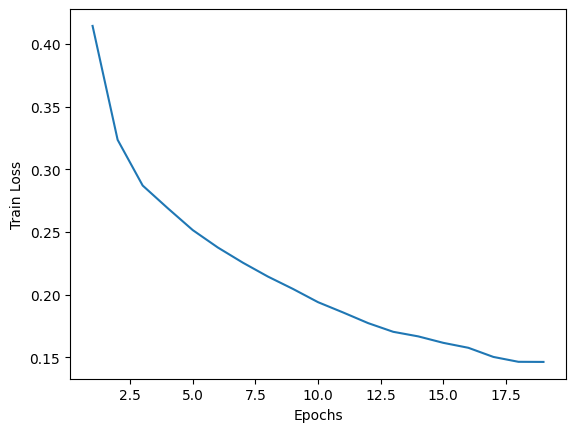

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1,20), loss_lst)
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

## Evaluation


In [ ]:
# Define the validation seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        # Collect predictions and ground-truths and write them into
        # `preds` and `ground_truths`.
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
# print(pred)
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")

100%|██████████| 79/79 [00:01<00:00, 43.50it/s]


Validation AUC: 0.9270


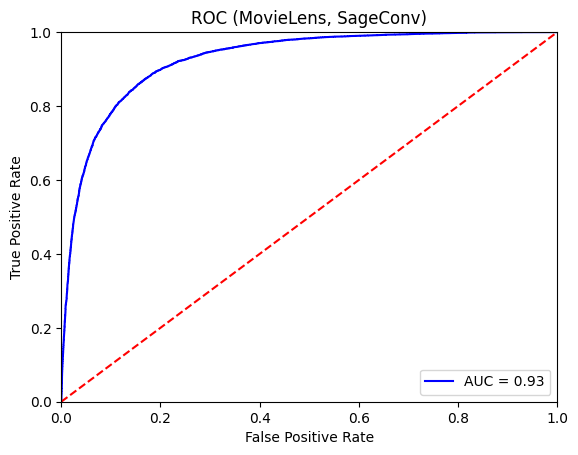

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt


fpr, tpr, threshold = metrics.roc_curve(ground_truth, pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC (MovieLens, SageConv)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


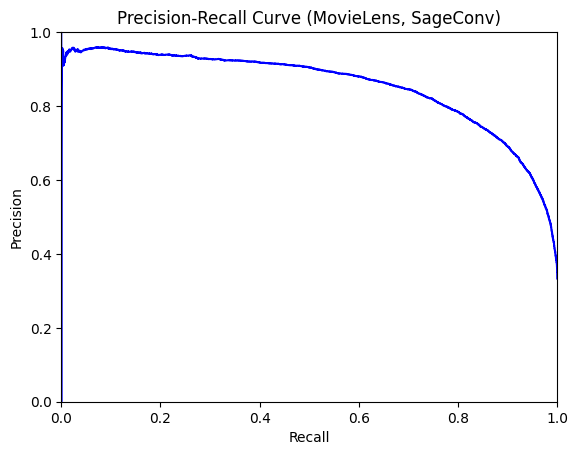

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(ground_truth, pred)

plt.title('Precision-Recall Curve (MovieLens, SageConv)')
plt.plot(recall, precision, 'b')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()




---


# Rough Work

In [ ]:
import torch.nn.functional as F

In [ ]:
m = torch.nn.Sigmoid()
pred_prob = m(torch.tensor(pred))

roc_auc_score(ground_truth, pred_prob)

0.926461406722104

In [ ]:
pred

array([ -5.429832  ,   2.750652  ,   2.542671  , ..., -13.739972  ,
         0.26229906,  -3.176751  ], dtype=float32)

In [ ]:
roc_auc_score(ground_truth, pred)

0.926461409181115

In [ ]:
roc_auc_score(ground_truth, [1 if x>0 else 0 for x in pred])

0.7939353367053457

In [ ]:
len(ground_truth), sum(ground_truth)

(30249, 10083.0)

In [ ]:
ground_truth, pred

(array([1., 1., 1., ..., 0., 0., 0.], dtype=float32),
 array([-0.8687299, -5.031821 , -3.3144045, ..., -1.9972129,  1.4597307,
        -3.5701156], dtype=float32))

In [ ]:
import numpy as np

auc_lst = []

for i in np.linspace(-1,1,100):
  auc_score = roc_auc_score(ground_truth, [1 if x>i else 0 for x in pred])
  auc_lst.append(auc_score)

In [ ]:
max(auc_lst)

0.8482842408013487

In [ ]:
import pandas as pd
import numpy as np

user_movies = val_data[('user', 'rates', 'movie')]['edge_label_index'].numpy()
actual_edge_exists = val_data[('user', 'rates', 'movie')]['edge_label'].numpy()
pred

val_pred = np.vstack([user_movies, actual_edge_exists, pred])
val_pred = val_pred.transpose()
val_pred = pd.DataFrame(val_pred)
val_pred.columns = ['user','movie','edge_exists','sim_score']
val_pred.head()

,user,movie,edge_exists,sim_score
0,325.0,138.0,1.0,-0.868730
1,92.0,1404.0,1.0,-5.031821
2,150.0,620.0,1.0,-3.314404
3,75.0,1375.0,1.0,-3.949197
4,578.0,1543.0,1.0,-0.541766


In [ ]:
val_pred['rank'] = val_pred.groupby('user')['sim_score'].rank(method='dense', ascending=False)
k = 50
val_pred['pred_top20'] = val_pred.apply(lambda x: 1 if x['rank']<=k and x['sim_score']>-0.5 else 0, axis=1)

from sklearn.metrics import precision_score, recall_score

recall_score(val_pred['edge_exists'],val_pred['pred_top20']), precision_score(val_pred['edge_exists'],val_pred['pred_top20'])


(0.6138054150550432, 0.8084911822338341)

In [ ]:
roc_auc_score(val_pred['edge_exists'],val_pred['pred_top20'])

0.7705543984925122